# Part 1: Getting the dataset

In [55]:
import requests
from matplotlib import pyplot as plt
import numpy as np
import csv
import pandas as pd
from pandas import DataFrame
%matplotlib inline

Downloading the dataset and displaying the top rows:

In [2]:
#Storing the dataset as a dictionary (might be useful later on)
data_dict = []
with open('data\sfpd_incidents.csv','rb') as f:
    reader = csv.DictReader(f)
    for line in reader:
        data_dict.append(line)

In [3]:
#Storing the dataset as a Pandas DataFrame
#Easily create DataFrame from list of dictionaries
data_dataframe = DataFrame(data_dict)
data_dataframe.head(5)

,Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,Time,X,Y
0,18TH ST / VALENCIA ST,NON-CRIMINAL,01/19/2015,Monday,LOST PROPERTY,150060275,"(37.7617007179518, -122.42158168137)",MISSION,15006027571000,NONE,14:00,-122.42158168137,37.7617007179518
1,300 Block of LEAVENWORTH ST,ROBBERY,02/01/2015,Sunday,"ROBBERY, BODILY FORCE",150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821003074,NONE,15:45,-122.414406029855,37.7841907151119
2,300 Block of LEAVENWORTH ST,ASSAULT,02/01/2015,Sunday,AGGRAVATED ASSAULT WITH BODILY FORCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821004014,NONE,15:45,-122.414406029855,37.7841907151119
3,300 Block of LEAVENWORTH ST,SECONDARY CODES,02/01/2015,Sunday,DOMESTIC VIOLENCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821015200,NONE,15:45,-122.414406029855,37.7841907151119
4,LOMBARD ST / LAGUNA ST,VANDALISM,01/27/2015,Tuesday,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",150098226,"(37.8004687042875, -122.431118543788)",NORTHERN,15009822628160,NONE,19:00,-122.431118543788,37.8004687042875


> *The file has may column, and today we'll be working with:*
* The various categories of crimes -> Attribute **Category**
* Crime over the years -> Attribute **Date**
* What time of day do crimes occur? -> Attribute **Time**
* And do certain crime-types tend to happen in specific neighborhoods? -> Attribute **Location**

> *We'll play around with geo-data.*

> * What is the total number of incidents in the CSV file?

In order to get the total number of incidents it's easy to count the different values of `IncidntNum` (it would be probably the same to just count the total number of rows, if `IncidntNum` is a primary key):

In [4]:
total_rows = data_dataframe.count()
print 'Total number of incidents:',total_rows['IncidntNum']

Total number of incidents: 2023865


# Part 2: Working with data
## 2.1 The types of crime and their popularity over time

> *The types of crime and their popularity over time. The first field we'll dig into is the column "Category".*
* Create a set() of all the categories of crime in the dataset. How many are there?

In [38]:
num_categories = data_dataframe.Category.nunique()
print 'Total unique categories:',num_categories
all_categories = set()
for data in data_dict:
    all_categories.add(data['Category'])

#Just a check
len(all_categories) == num_categories

Total unique categories: 39


True

> * Now count the number of occurrences of each category in the dataset. What is the most commonly occurring category of crime? What is the least frequently occurring?

Now counting the occurrencies of each category in the dataset: achieved through a simple group by.

In [46]:
categories = data_dataframe.groupby('Category')['Category'].count().reset_index(name="Count")
categories = categories.sort_values(by='Count',ascending=True) #Getting sorted values
categories

,Category,Count
33,TREA,13
22,PORNOGRAPHY/OBSCENE MAT,50
14,GAMBLING,326
29,"SEX OFFENSES, NON FORCIBLE",376
10,EXTORTION,669
3,BRIBERY,732
2,BAD CHECKS,891
11,FAMILY OFFENSES,1128
31,SUICIDE,1197
18,LOITERING,2382


In [47]:
print 'Least occurring category:'
categories.head(1)

Least occurring category:


,Category,Count
33,TREA,13


In [48]:
print 'Most occurring category:'
categories.tail(1)

Most occurring category:


,Category,Count
16,LARCENY/THEFT,422170


> * Create a histogram over crime occurrences.

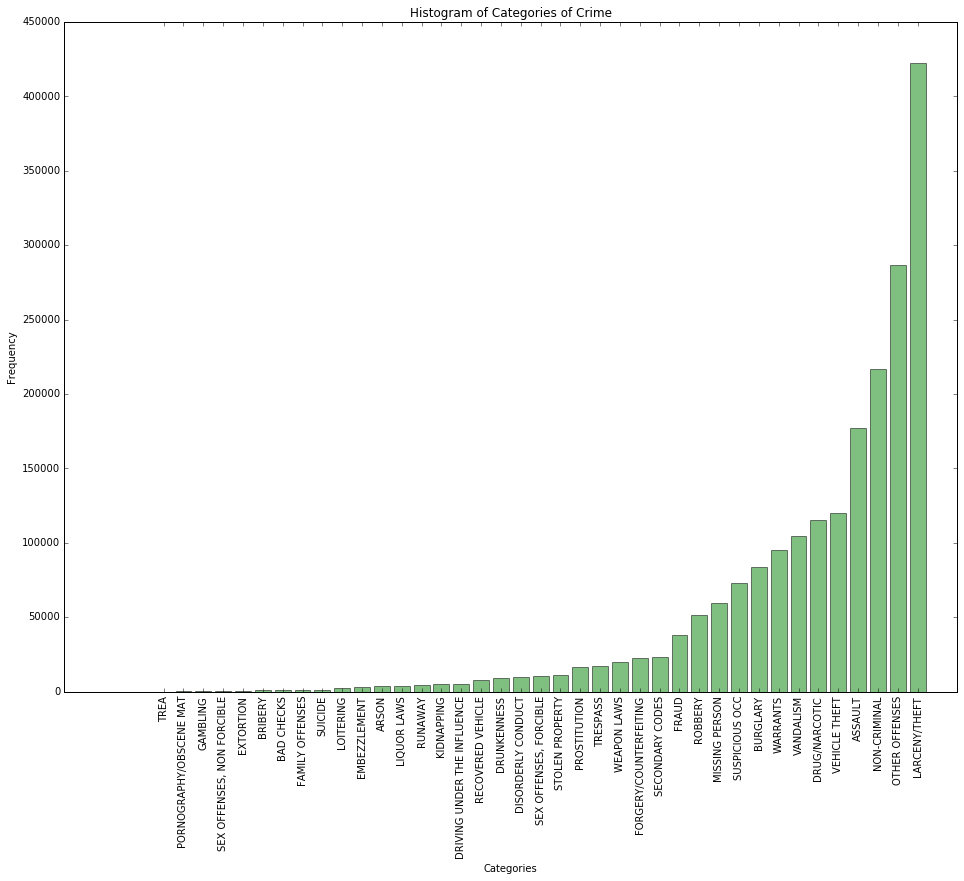

In [74]:
categories_names = list(categories['Category']) # X-ticks labels
y = list(categories['Count']) #Y-values
x = np.arange(len(categories_names)) #X-values

plt.figure(figsize=(16,12))
plt.bar(x,y,alpha=.5,color='green',align='center')
plt.xticks(x,categories_names,rotation='vertical')
plt.title("Histogram of Categories of Crime")
plt.xlabel('Categories')
plt.ylabel("Frequency")
plt.show()

> *Now it's time to explore how the crime statistics change over time. To start off easily, let's count the number of crimes per year for the years 2003-2016 (the full years in the database). What's the average number of crimes per year?*

The basic idea to group by year is to create a new column in the dataset called `Year` and group by this one. In order to do so, it's easy to apply a lambda function (`getYear()`) to extract the year from the already existing `Date` column:

In [114]:
def getYear(date):
    return int(date.split('/')[2])

#Adding new column in the dataframe
data_dataframe['Year'] = data_dataframe['Date'].apply(lambda x: getYear(x))

#New dataframe with occurrencies of crimes per year
crimes_per_date = data_dataframe.groupby('Year')['Year'].count().reset_index(name='Count')

In [115]:
crimes_per_date

,Year,Count
0,2003,149176
1,2004,148148
2,2005,142186
3,2006,137853
4,2007,137639
5,2008,141311
6,2009,139860
7,2010,133523
8,2011,132697
9,2012,140854


In [116]:
print 'Average number of crimes per year: %d' %crimes_per_date['Count'].mean()

Average number of crimes per year: 134924


> * *Police chief Suneman is interested in the temporal development of only a subset of categories, the so-called focus crimes. Now create bar-charts displaying the year-by-year development of each of these categories across the years 2003-2016.*

In [117]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

# Keep only the Categories of the list in a separate dataframe and filter only relevant columns
focus_df = data_dataframe.filter(items=['Category', 'Year']) 
focus_df = focus_df[focus_df['Category'].isin(focuscrimes)] #Correct way of filtering rows
focus_df.head()

,Category,Year
1,ROBBERY,2015
2,ASSAULT,2015
4,VANDALISM,2015
7,VANDALISM,2015
8,BURGLARY,2015


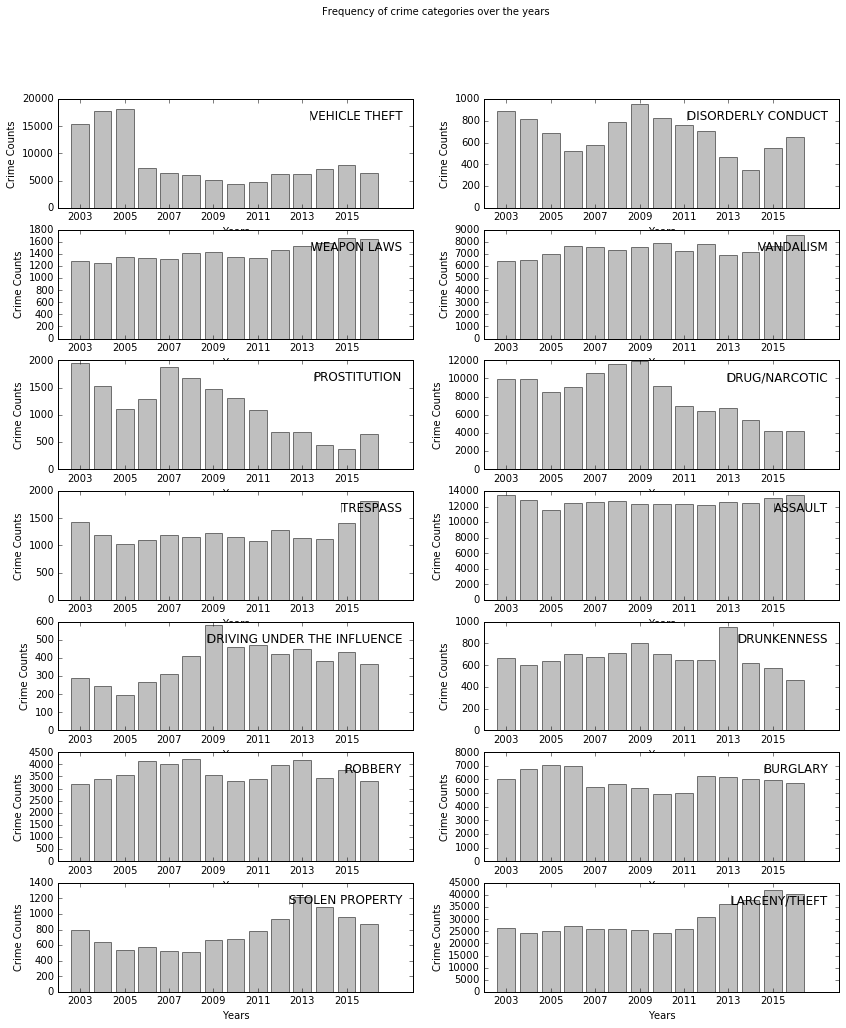

In [119]:
plt.figure(figsize = (14,16))
plt.suptitle('Frequency of crime categories over the years')
for index,crime in enumerate(focuscrimes):
    # Create a matrix of subplots with 7 rows and two columns
    plt.subplot(7,2,index+1)
     
    # Create a sub-df for each category
    temp_df = focus_df[focus_df['Category']==crime]
    
    # Drop column category from the new df to keep only year
    temp_df = temp_df.drop('Category', axis=1) # axis=1 means column
    
    # Drop 2017 as it could be misleading as only few values for the first two months exist
    temp_df = temp_df[temp_df.Year != 2017]
    
    # Count frequency of crime occurence
    occurrencies = temp_df.groupby('Year')['Year'].count().reset_index(name='count').sort_values(by='Year', ascending=True)
    
    # Assign x and y values
    x = occurrencies['Year']
    y = occurrencies['count']

    plt.bar(x,y,align='center',alpha=.5, color='grey',label=crime)
    plt.xticks(np.arange(2003,2017,2))
    plt.ylabel("Crime Counts")
    plt.xlabel("Years")
    plt.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    
# Show the barplot
plt.show()

> * *Comment on at least three interesting trends in your plot.*

1. **VEHICLE THEFT**: drastically decreased after 2006, with again a slight increase from 2011 to 2015;
2. **DISORDERLY CONDUCT**: really unstable trend over the years;
3. **WEAPON LAWS**: slight rise over the years;
4. **VANDALISM**: again, slight rise over the years, it represents one of the most frequent crimes in a year;
5. **PROSTITUTION**: definitely decreased in the last 10 years;

etc...

## 2.2 The types of crime and their popularity across the 24 hours of the day
> * *First, plot a simple histogram of the number of crimes per hour in the dataset. There's a little strange peak at 12:00 - what do you think is going on there?*

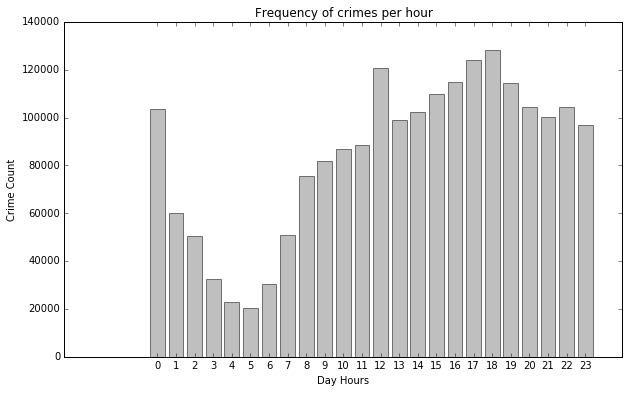

In [123]:
# Create a function that returns the time
def getHour(s):
    return int(s.split(':')[0])

# Now create a new column named hour and store the values of the above function
data_dataframe['Hour']= data_dataframe['Time'].apply(lambda x: getHour(x))

# List the number of crimes per year
crime_occurencies_hour = data_dataframe.groupby('Hour')['Hour'].count().reset_index(name='count').sort_values(by='Hour', ascending=True)

# Assign x and y values
x = crime_occurencies_hour['Hour']
y = crime_occurencies_hour['count']

# Assign the size of the plot before declaring the plot
plt.figure(figsize= (10,6))

# Give the x and y values to the barplot
plt.bar(x, y, align = 'center', color='grey', alpha=.5)

# Give labels and titles
plt.ylabel("Crime Count")
plt.title("Frequency of crimes per hour")
plt.xticks(range(0,24,1))
plt.xlabel("Day Hours")

# Show the barplot
plt.show()

> * *Next create a plot of the count of each crime category across the 24 hours of the day.*

In [125]:
# Keep only the Categories of the list in a seperate dataframe
focus_df2 = data_dataframe.filter(items=['Category', 'Hour']) 
focus_df2 = focus_df2[focus_df2['Category'].isin(focuscrimes)]
focus_df2.head()

,Category,Hour
1,ROBBERY,15
2,ASSAULT,15
4,VANDALISM,19
7,VANDALISM,21
8,BURGLARY,16


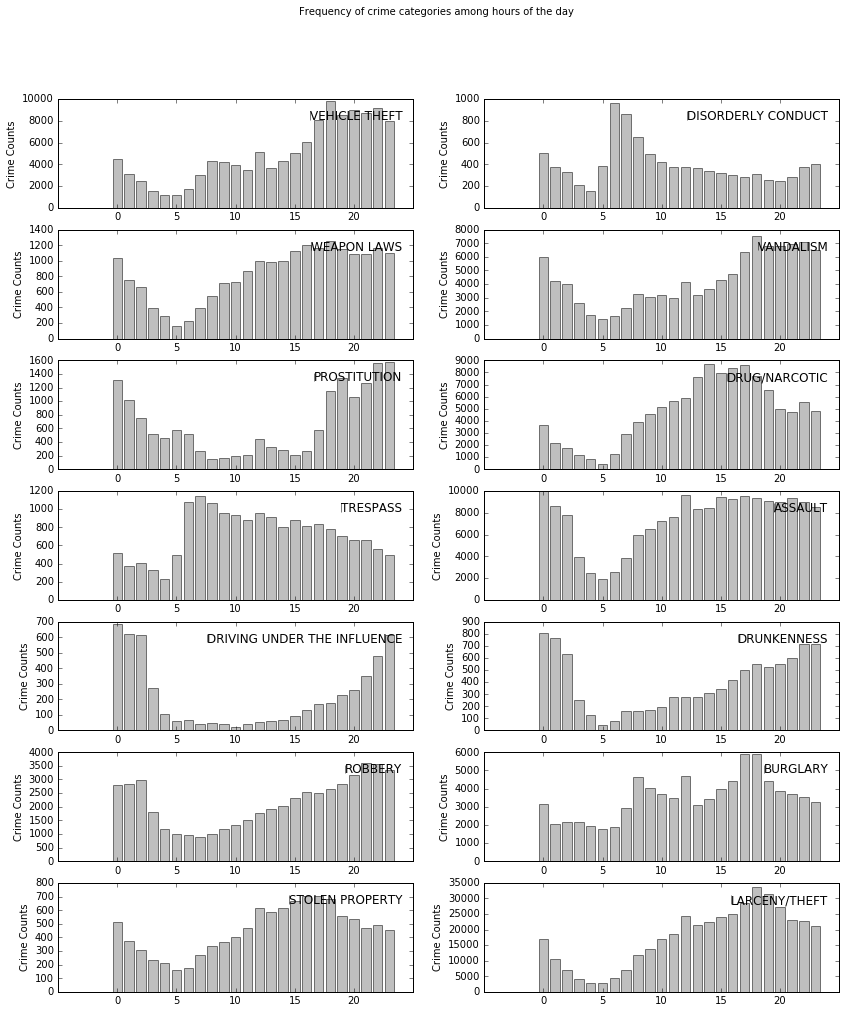

In [127]:
plt.figure(figsize = (14,16))
plt.suptitle('Frequency of crime categories among hours of the day')
for index,crime in enumerate(focuscrimes):
    # Create a matrix of subplots with 7 rows and two columns
    plt.subplot(7,2,index+1)
     
    # Create a sub-df for each category
    temp_df2 = focus_df2[focus_df2['Category']==crime]
    
    # Drop column category from the new df to keep only year
    temp_df2 = temp_df2.drop('Category', axis=1) # axis=1 means column
    
    # Drop 2017 as it could be misleading as only few values for the first two months exist
    temp_df2 = temp_df2[temp_df2.Hour != 2017]
    
    # Count frequency of crime occurence
    occurence = temp_df2.groupby('Hour')['Hour'].count().reset_index(name='count').sort_values(by='Hour', ascending=1)
    
    # Assign x and y values
    x = occurence['Hour']
    y = occurence['count']

    plt.bar(x,y,align='center',alpha=.5, color='grey',label=crime)
    plt.xticks(np.arange(0,24,5))
    plt.ylabel("Crime Counts")
    plt.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    
# Show the barplot
plt.show()

## 2.3 The types of crime and how they take place across San Francisco's police districts
> * *So now we'll be combining information about PdDistrict and Category to explore differences between SF's >neighborhoods. First, simply list the names of SF's 10 police districts.*

In [131]:
# Create a list of unique values of districts excluding nulls
districts = [i for i in data_dataframe.PdDistrict.unique() if pd.notnull(i) and i!='']
print 'The %d police districts of SanFrancisco are: \n%s' % (len(districts),districts)

The 10 police districts of SanFrancisco are: 
['MISSION', 'TENDERLOIN', 'NORTHERN', 'RICHMOND', 'BAYVIEW', 'CENTRAL', 'PARK', 'TARAVAL', 'SOUTHERN', 'INGLESIDE']


> * *Which has the most crimes? Which has the most focus crimes?*

In [136]:
# Keep only the Category and the District column
catdist_df = data_dataframe.filter(items=['Category', 'PdDistrict']) 
catdist_df = catdist_df[catdist_df['PdDistrict'].isin(districts)]

# List the number of crimes per District
crime_occurencies_district = catdist_df.groupby('PdDistrict')['PdDistrict'].count().reset_index(name='count').sort_values(by='count', ascending=0)

# Print the district with the most crimes
print 'The districts with the most crimes are:\n'
crime_occurencies_district = crime_occurencies_district.reset_index().drop('index', axis=1)
crime_occurencies_district.head()

The districts with the most crimes are:



,PdDistrict,count
0,SOUTHERN,364516
1,MISSION,273386
2,NORTHERN,246991
3,BAYVIEW,203841
4,CENTRAL,202342


In [135]:
# Filter out only the focus crimes
catdistfocus_df = catdist_df[catdist_df['Category'].isin(focuscrimes)]

# List the number of crimes per District
crime_occurencies_district_focus = catdistfocus_df.groupby('PdDistrict')['PdDistrict'].count().reset_index(name='count').sort_values(by='count', ascending=0)

# Print the district with the most focus crimes
print 'The districts with the most focus crimes are:\n'
crime_occurencies_district_focus = crime_occurencies_district_focus.reset_index().drop('index', axis=1)
crime_occurencies_district_focus.head()

The districts with the most focus crimes are:



,PdDistrict,count
0,SOUTHERN,208888
1,NORTHERN,157664
2,MISSION,151657
3,CENTRAL,125981
4,BAYVIEW,107768


> Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes >that happen much more in certain neighborhoods than what's typical.*
* *First, we need to calculate the relative probabilities of seeing each type of crime in the dataset as a whole. Let's call it P(crime).*

> * *Next, we calculate that same probability distribution but for each PD district, let's call that P(crime|district).*

> * *Now we look at the ratio P(crime|district)/P(crime). That ratio is equal to 1 if the crime occurs at the same level within a district as in the city as a whole. If it's greater than one, it means that the crime occurs more frequently within that district. If it's smaller than one, it means that the crime is rarer within the district in question than in the city as a whole.*

> * *For each district plot these ratios for the 14 focus crimes.*